# Python for STEM - Week 2 (Advanced)  

## Day 4 - Part 1: Supervised learning - Regression

In this notebook, we will focus on examples of supervised machine learning. More specifically, we will be doing regression using Scikit-learn, one of the machine learning packages in Python. Before we start, here we first import all the packages that we need for this notebook. 

All the machine learning functions we will use in Day 3 and Day 4 all comes from [scikit-learn](https://scikit-learn.org/stable/index.html). You can find very detailed descriptions on many machine learning models included in the package user guide and various examples. This would be a good place to start when you want to adopt machine learning for your own research/work.  




In [ ]:
## In this cell, we import all the packages needed for this notebook
import numpy as np                  ## packages for data handling
import pandas as pd                 
import matplotlib.pyplot as plt     ## packages for visualization 
import seaborn as sbn 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Data Ingest

In this notebook, we will be using another real world problem of predictive modeling of the concentration of PM2.5 in Beijing using hourly weather information. PM2.5 refers to atmospheric particulate matter (PM) that have a diameter less than 2.5 $\mu m$. The data is between 2010 and 2014. The data is stored as a comma separated value (CSV) data file, with 11 columns. The table below shows the meaning of each column.  

| Variable name | Full name |
|-:|-:|
|*year*|Year of observation| 
|*month*|Month of observation|
|*day*|Day of observation|
|*hour*|Hour of observation|
|*pm2.5*|Concentration of PM 2.5 ($\mu g/m^3$)|
|*DEWP*|Dew Point ($^\circ C$)|
|*TEMP*|Temperature ($^\circ C$)|
|*PRES*|Pressure (hPa)|
|*WIND*|Wind speed (m/s)|
|*TSNOW*|Continuos hours of snow|
|*TRAIN*|Continuos hours of rain|

In [ ]:
filename = "https://raw.githubusercontent.com/uofscphysics/STEM_Python_Course/Summer2020/02_Week2/Data/04_Beijing_PM2.5_hourly_20100101-20141231.csv"
PMdata = pd.read_csv(filename, index_col=None)
print( PMdata.head() )
print( PMdata.shape )

## We see there are mission values at the begining so we drop these missing 
## values in the dataset
PMdata = PMdata.dropna()
print( PMdata.head() )

   year  month  day  hour  pm2.5  DEWP  TEMP    PRES   WIND  TSNOW  TRAIN
0  2010      1    1     0    NaN   -21 -11.0  1021.0   1.79      0      0
1  2010      1    1     1    NaN   -21 -12.0  1020.0   4.92      0      0
2  2010      1    1     2    NaN   -21 -11.0  1019.0   6.71      0      0
3  2010      1    1     3    NaN   -21 -14.0  1019.0   9.84      0      0
4  2010      1    1     4    NaN   -20 -12.0  1018.0  12.97      0      0
(43824, 11)
    year  month  day  hour  pm2.5  DEWP  TEMP    PRES  WIND  TSNOW  TRAIN
24  2010      1    2     0  129.0   -16  -4.0  1020.0  1.79      0      0
25  2010      1    2     1  148.0   -15  -4.0  1020.0  2.68      0      0
26  2010      1    2     2  159.0   -11  -5.0  1021.0  3.57      0      0
27  2010      1    2     3  181.0    -7  -5.0  1022.0  5.36      1      0
28  2010      1    2     4  138.0    -7  -5.0  1022.0  6.25      2      0


In [ ]:
## Since we will not use the time information for modeling, we here only keep
## pm2.5 and weather information
PMdata = PMdata.iloc[:,4:]
print ( PMdata.head() )

    pm2.5  DEWP  TEMP    PRES  WIND  TSNOW  TRAIN
24  129.0   -16  -4.0  1020.0  1.79      0      0
25  148.0   -15  -4.0  1020.0  2.68      0      0
26  159.0   -11  -5.0  1021.0  3.57      0      0
27  181.0    -7  -5.0  1022.0  5.36      1      0
28  138.0    -7  -5.0  1022.0  6.25      2      0


Now we can look at the time-series of our data.

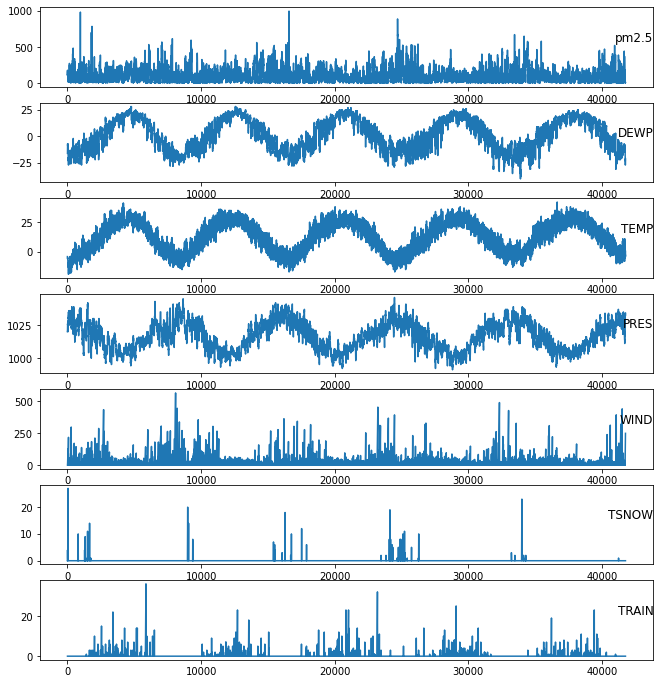

In [ ]:
# specify columns to plot
index = [0, 1, 2, 3, 4, 5, 6]
i = 1
# plotting each column
plt.figure(figsize=(11, 12))
for ind in index:
	plt.subplot(len(index), 1, i)
	plt.plot(PMdata.iloc[:, ind].values)
	plt.title(PMdata.columns[ind], y=0.5, loc='right')
	i += 1
plt.show()

## Data Scaling  

From the data, we see there are large differences of the magnitude of different variables, which can cause issues when we directly build our model with current data. Data with notably larger magnitude could dominate the model performance. To avoid that, we usually scale our data to [0, 1], or [-1, 1]. In other cases, we can also scale all variables to a distribution with 0 mean and standard deviation of 1.  

In [ ]:
## import function to perform data scaling
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(PMdata)


In [ ]:
## After scaling our data, we can separate the data into training and testing data
from sklearn.model_selection import train_test_split

## Independent variables for our model (weather data) 
X = scaled[:,1:]
## Target output for our model (pm2.5)
y = scaled[:,0]
## We are spliting our data set into training and testing sets based on a 60:40 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
print( X_train.shape, y_train.shape)


(25054, 6) (25054,)


## Neural Network 

Neural network is the backbone of the recent booming of the deep learning application in many discplines. The basis of neural network is using multiple linear equation to mimic possible nonlinear patterns in the data. The main hyperparameters that could affect the performance includes the number of layers and neurons in each layer. Additionally, the regularization penalty as well as the activation function could also change the results notably. So it usually requires an intensive traning process to find the best combination of model hyperparameters.

Now, let's first try to see the impact of number of layers and number of neurons in each layer for the model performance.


In [ ]:
## Import the decision tree model
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

## This time, let's try to minimizing the sample size and accelerating our training process
## We vwill just use one year worth of data for this training process
hour_index = 365*24*2
X_train_2yr = scaled[:hour_index, 1:]
X_test_2yr = scaled[hour_index:, 1:]
y_train_2yr = scaled[:hour_index, 0]
y_test_2yr = scaled[hour_index:, 0]

## define our model
nnModel = MLPRegressor(random_state=42)

## Define parameter grid for tunning, which is different list of the neurons
## 1-hidden layer, 2-hidden layer, 3-hidden layer
param_grid = {
    'hidden_layer_sizes': [(10,), (20,), (50,),
                           (10,10), (20,10), (50,10),
                           (10,10,10), (20,20,10), (50, 20, 10)]
}

## define grid search process
gridsearch_cv_obj = GridSearchCV(
    nnModel, 
    param_grid, 
    scoring=make_scorer(r2_score), 
    cv=KFold(n_splits=5),
    n_jobs=-1,
  )

gridsearch_cv_obj.fit(X_train_2yr, y_train_2yr)



GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             error_score=nan,
             estimator=MLPRegressor(activation='relu', alpha=0.0001,
                                    batch_size='auto', beta_1=0.9, beta_2=0.999,
                                    early_stopping=False, epsilon=1e-08,
                                    hidden_layer_sizes=(100,),
                                    learning_rate='constant',
                                    learning_rate_init=0.001, max_fun=15000,
                                    max_iter=200, momentum=0.9,
                                    n_iter_no_change=10,
                                    n...5,
                                    random_state=42, shuffle=True,
                                    solver='adam', tol=0.0001,
                                    validation_fraction=0.1, verbose=False,
                                    warm_start=False),
             iid='deprecated', n_jobs=-1,
         

In [ ]:
print( 'Best model hyperparameter for the neural network regressor is:' )
print( gridsearch_cv_obj.best_params_)


Best model hyperparameter for the neural network regressor is:
{'hidden_layer_sizes': (50, 20, 10)}


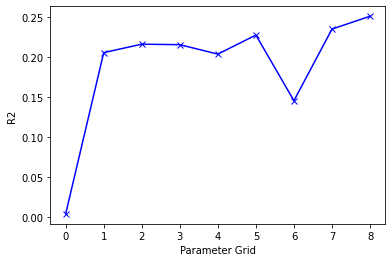

In [ ]:
## Let's look at how the model performance change with the number of layers
mean_r2 = gridsearch_cv_obj.cv_results_['mean_test_score']
plt.figure()
plt.plot(mean_r2, 'bx-')
plt.xlabel('Parameter Grid')
plt.ylabel('R2')
plt.show()

In [ ]:
## Now, we can define a best neural network model based on our grid search
nnModel = MLPRegressor(hidden_layer_sizes=(50,20,10))

nnModel.fit(X_train_2yr, y_train_2yr)

nn_predicted = nnModel.predict(X_test_1yr)

nnRMSE = np.sqrt(mean_squared_error(y_test_1yr, nn_predicted))
print( nnRMSE )

0.07992455772418675


## Activation Function & Regularization

Assume that we fix the structure of the model in terms of the number of layers, and number of neurons in each layer. We now want to examine the impact of the activation function and regularization penalty for our model.  


In [ ]:
## Let's first define our model parameter grids
param_grid = {
    'activation': ['relu', 'tanh'],
    'alpha': [0.00001, 0.0001, 0.001, 0.01]
}

## deinfe the number of layers and neurons in the model
nnModel = MLPRegressor(hidden_layer_sizes= (50,20,10), random_state=42)

## define grid search process
gridsearch_cv_obj = GridSearchCV(
    nnModel, 
    param_grid, 
    scoring=make_scorer(r2_score), 
    cv=KFold(n_splits=5),
    n_jobs=-1,
  )

gridsearch_cv_obj.fit(X_train_2yr, y_train_2yr)



GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             error_score=nan,
             estimator=MLPRegressor(activation='relu', alpha=0.0001,
                                    batch_size='auto', beta_1=0.9, beta_2=0.999,
                                    early_stopping=False, epsilon=1e-08,
                                    hidden_layer_sizes=(50, 20, 10),
                                    learning_rate='constant',
                                    learning_rate_init=0.001, max_fun=15000,
                                    max_iter=200, momentum=0.9,
                                    n_iter_no_change=10,
                                    nesterovs_momentum=True, power_t=0.5,
                                    random_state=42, shuffle=True,
                                    solver='adam', tol=0.0001,
                                    validation_fraction=0.1, verbose=False,
                                    warm_start=False),
             i

{'activation': 'relu', 'alpha': 0.0001}


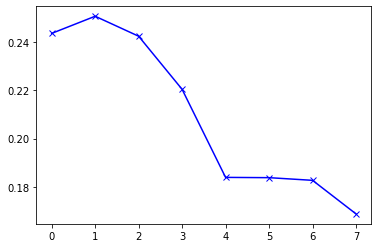

In [ ]:
## Let's print out the best model hyperparameter combination
print(gridsearch_cv_obj.best_params_)

## Calculating the mean and standard deviation of the accuracy for the model test scores
mean_test_r2 = gridsearch_cv_obj.cv_results_["mean_test_score"]
stds_test_r2 = gridsearch_cv_obj.cv_results_["std_test_score"]

plt.plot(mean_test_r2, 'bx-')

In [ ]:
## Now we can create a final prediction with the optimized model hyperparameters
nnModel = MLPRegressor(hidden_layer_sizes=(50,20,10),
                       activation='relu',
                       alpha = 0.0001)

nnModel.fit(X_train_2yr, y_train_2yr)

nn_predicted = nnModel.predict(X_test_2yr)

nnRMSE = np.sqrt(mean_squared_error(y_test_2yr, nn_predicted))
print(nnRMSE)

0.07846505175217186


<Figure size 432x288 with 0 Axes>

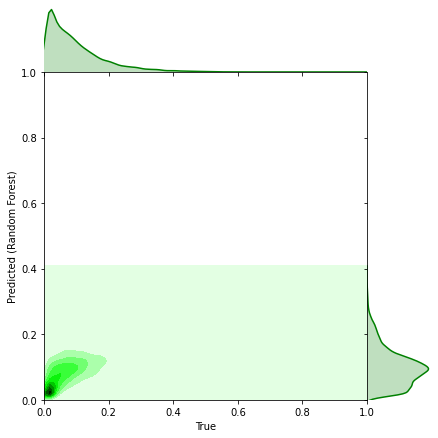

In [ ]:
## To show the prediction results, we can also plot a kernal density plot between 
## predicted value and testing value
plt.figure()
fig = sbn.jointplot(y_test, nn_predicted, xlim=[0,1], ylim=[0,1],
                    kind="kde", space=0, color="g")
fig.set_axis_labels(xlabel='True', ylabel='Predicted (Random Forest)')
plt.show()

<Figure size 432x288 with 0 Axes>

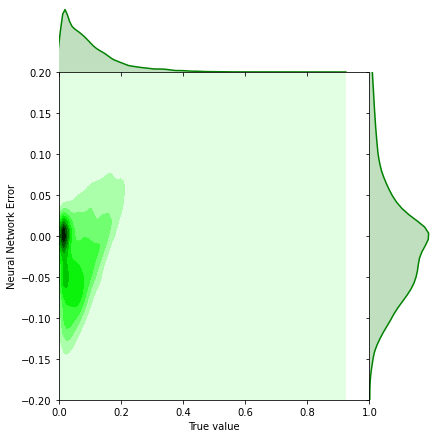

In [ ]:
## We can also compare the model error between decision tree and random forest
## and see the performance differences.
plt.figure()
fig = sbn.jointplot(y_test_2yr, 
                    y_test_2yr - nn_predicted, 
                    xlim=[0,1], ylim=[-0.2,0.2],
                    kind="kde", space=0, color="g")
fig.set_axis_labels(xlabel='True value', ylabel='Neural Network Error')
plt.show()

In [ ]:
## Earlier, we optimize the hyperparameter separately, which might not give us the best results.
## Can you try to do the optimization together for both number of neurons, activation function, as well as regularization?

